<a href="https://colab.research.google.com/github/Potdooshami/2H_TaSe2_Tc_STM/blob/main/phasemapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Declare functions

##Main function

In [1]:
import numpy as np
## Divide ##
def z3z3split(phi1,phi2):
  # phi1 from [0,2pi)
  # phi2 from [0,2pi)
  phi1 = phi1%(2*np.pi) # R -> [0,2pi)
  phi2 = phi2%(2*np.pi)
  phi1i = phi1/(2*np.pi) # [0,2pi) -> [0,1)
  phi2i = phi2/(2*np.pi)
  z3z31, rphi1 = divmod(phi1i, 1/3)
  z3z32, rphi2 = divmod(phi2i, 1/3)
  z3z3 = [z3z31,z3z32] # {0,1,2} #len2 list
  rphi12 = [rphi1*3,rphi2*3] # [0,1) #len2 list
  return z3z3,rphi12

def rlsplit(rphi12):
  is_close_10 = rphi12[0]>rphi12[1]#r-like|-> T, g-like|-> F
  if not is_close_10:
    rphi12 = [rphi12[1],rphi12[0]]
  rphi12 = np.array(rphi12)
  rphi12 = rphi12.reshape(2,1) #Basis B
  I_C__B = np.array([[1,-1],[0,1]]) #Identity
  rphi12_C = I_C__B@rphi12 #Basis C
  v_c1 = rphi12_C[0,0]
  v_c2 = rphi12_C[1,0]
  baryHHH_foo = np.array([1-v_c1-v_c2,v_c1,v_c2 ])
  baryHHH_foo = baryHHH_foo.reshape(3,1) #order of index: (00),(??),(11)
  return is_close_10,baryHHH_foo

def sixsplit(baryHHH_foo):
  p_BarHHH = np.sort(baryHHH_foo, axis=0)[::-1]
  z6 = np.argsort(baryHHH_foo, axis=0)[::-1]
  p_AffHHH = p_BarHHH[1:]
  I_AffHAC__AffHHH = np.array([[1,2],[1,-1]])
  p_AffHAC = I_AffHAC__AffHHH@p_AffHHH
  p_BarHAC = np.array([1-p_AffHAC[0]-p_AffHAC[1],p_AffHAC[0],p_AffHAC[1]])
  baryHAC_foo = p_BarHAC
  return z6,baryHAC_foo

## Conquer ##
def get_baryHHH(baryHHH_foo,is_close_10):
  baryHHH = np.zeros(4)
  baryHHH[0] = baryHHH_foo[0,0]
  baryHHH[3] = baryHHH_foo[2,0]
  # print('here',not(is_close_10)+1)
  baryHHH[(not(is_close_10))+1] = baryHHH_foo[1,0]
  return baryHHH #order of index: (00),(10),(01),(11)
def get_baryHAC(is_close_10,baryHAC_foo):
  # baryHAC = np.zeros(3)
  baryHAC = baryHAC_foo
  if not(is_close_10):
    baryHAC = baryHAC_foo[[0,2,1],[0]]
  return baryHAC #order of index: H,10L,01L
def phaseInfo(phi1,phi2):
  z3z3,rphi12 = z3z3split(phi1,phi2)
  is_close_10,baryHHH_foo = rlsplit(rphi12)
  z6,baryHAC_foo = sixsplit(baryHHH_foo)
  baryHHH = get_baryHHH(baryHHH_foo,is_close_10)
  baryHAC = get_baryHAC(is_close_10,baryHAC_foo)
  return baryHHH,baryHAC,z3z3


## Sub function

In [2]:
def phaseInfo2(Phi1,Phi2):
  XY_shape = Phi1.shape
  BaryHHH = np.zeros((XY_shape[0],XY_shape[1],4))
  BaryHAC = np.zeros((XY_shape[0],XY_shape[1],3))
  Z3z3 = np.zeros((XY_shape[0],XY_shape[1],2))

  for i in range(XY_shape[0]):
    for j in range(XY_shape[1]):
      phi1_now = Phi1[i,j]
      phi2_now = Phi2[i,j]

      baryHHH,baryHAC,z3z3 = phaseInfo(phi1_now,phi2_now)

      BaryHHH[i,j,:] = baryHHH.flatten()
      BaryHAC[i,j,:] = baryHAC.flatten()
      Z3z3[i,j,0] = z3z3[0]
      Z3z3[i,j,1] = z3z3[1]

  return BaryHHH,BaryHAC,Z3z3

In [3]:
def return_input_and_output(func):
    """
    데코레이터: 함수 호출 시 입력값과 리턴값을 튜플로 묶어 반환합니다.
    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        # 1. 원래 함수를 호출하고 리턴값을 저장합니다.
        result = func(*args, **kwargs)

        # 2. 입력값(*args, **kwargs)과 리턴값(result)을 튜플로 묶어 반환합니다.
        #    입력값은 (위치 인자, 키워드 인자) 형태의 튜플로 구성됩니다.
        return ((args, kwargs), result)
    return wrapper

In [4]:
def generatePhi(lx,ly,resol):
  xx = np.linspace(-lx,lx,lx*resol + 1)
  yy = np.linspace(-ly,ly,ly*resol + 1)
  X,Y = np.meshgrid(xx,yy)
  I_XY__B = np.array([[1,-1/2],[0,np.sqrt(3)/2]])
  I_B__XY = np.linalg.inv(I_XY__B)

  XY_shape = X.shape;
  XY_size = X.size;
  grid_XY =  np.array([X.flatten(),Y.flatten()])
  grid_B = I_B__XY @ grid_XY
  grid_B0 = grid_B[0,:].reshape(XY_shape)
  grid_B1 = grid_B[1,:].reshape(XY_shape)

  Phi = np.stack((grid_B0,grid_B1),axis=2)

  return Phi

In [5]:
def addNoise(Phi,amp,sig):
  import scipy.ndimage
  if amp == 0:
    return Phi
  Phi_dirt = Phi.copy()
  np.random.seed(42)
  shap = Phi.shape
  foo1 = np.random.rand(shap[0],shap[1])
  foo2 = np.random.rand(shap[0],shap[1])

  foo1 = scipy.ndimage.gaussian_filter(foo1, sigma=sig)
  foo2 = scipy.ndimage.gaussian_filter(foo2, sigma=sig)

  foo1 = foo1-.5
  foo2 = foo2-.5

  Phi_dirt[:,:,0] = Phi_dirt[:,:,0] + foo1*amp
  Phi_dirt[:,:,1] = Phi_dirt[:,:,1] + foo1*amp
  return Phi_dirt

In [6]:
def visBasicInfo(Phi,Info):
  import matplotlib.pyplot as plt
  msb,nsb = 4,3
  HHH_holder =Info[0]
  HAC_holder=Info[1]
  z3z3_holder=Info[2]

  fig,axs = plt.subplots(msb,nsb,figsize=(10,10))
  axs[0,1].imshow(HHH_holder[:,:,0], origin='lower')
  axs[1,1].imshow(HHH_holder[:,:,1], origin='lower')
  axs[2,1].imshow(HHH_holder[:,:,2], origin='lower')
  axs[3,1].imshow(HHH_holder[:,:,3], origin='lower')

  axs[0,2].imshow(HAC_holder[:,:,0], origin='lower')
  axs[1,2].imshow(HAC_holder[:,:,1], origin='lower')
  axs[2,2].imshow(HAC_holder[:,:,2], origin='lower')

  axs[0,0].imshow(Phi[:,:,0], origin='lower')
  axs[1,0].imshow(Phi[:,:,1], origin='lower')

  axs[2,0].imshow(z3z3_holder[:,:,0], origin='lower')
  axs[3,0].imshow(z3z3_holder[:,:,1], origin='lower')

  tns = [['phi1','phi2','z3z3_1','z3z3_2'],['00','10','01','11'],['H','L10','L01']]

  for isb in range(msb):
    for jsb in range(nsb):
      axs[isb,jsb].set_xticks([])
      axs[isb,jsb].set_yticks([])
      axs[isb,jsb].plot(250,200,'ro')
      try:
        tn = tns[jsb][isb]
        axs[isb,jsb].set_title(tn)
      except:
        a = 's'


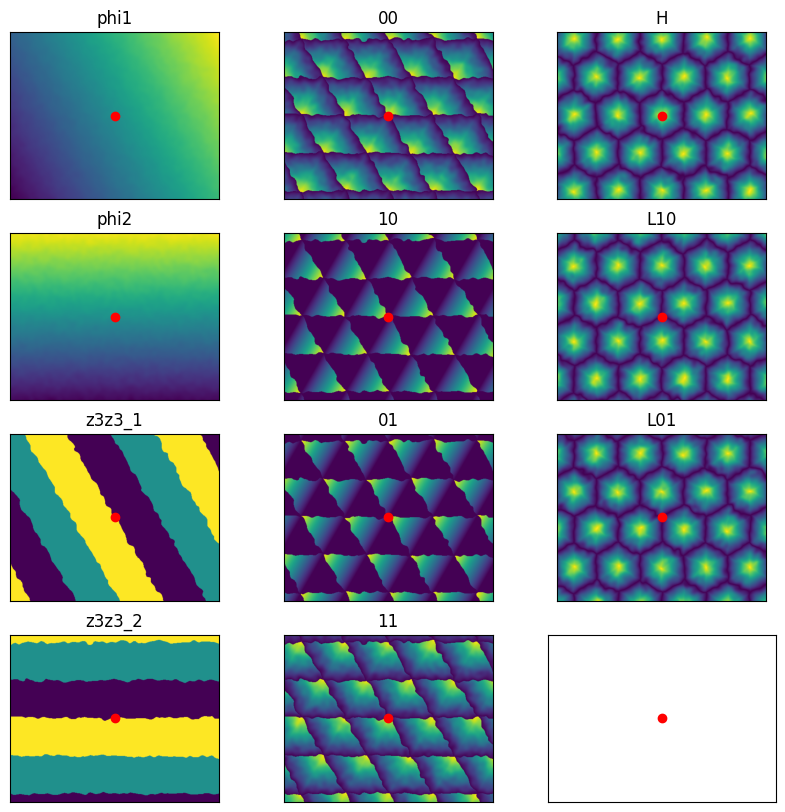

In [7]:
Phi = generatePhi(5,4,100)
Phi = addNoise(Phi,3,5)
Info = phaseInfo2(Phi[:,:,0],Phi[:,:,1])
visBasicInfo(Phi,Info)

# test functions go well

#Generate test phase map

In [8]:
xx = np.linspace(-5,5,501)
yy = np.linspace(-4,4,401)
X,Y = np.meshgrid(xx,yy)
I_XY__B = np.array([[1,-1/2],[0,np.sqrt(3)/2]])
I_B__XY = np.linalg.inv(I_XY__B)


In [9]:
XY_shape = X.shape;print(X.shape)
XY_size = X.size;print(X.size)
grid_XY =  np.array([X.flatten(),Y.flatten()])
grid_B = I_B__XY @ grid_XY
grid_B0 = grid_B[0,:].reshape(XY_shape)
grid_B1 = grid_B[1,:].reshape(XY_shape)

(401, 501)
200901


In [10]:
grid_Bflc = np.stack((grid_B0,grid_B1),axis=2)
grid_Bflc += np.random.rand(XY_shape[0],XY_shape[1],2)

In [11]:
XY_shape[0]
XY_shape[1]
HHH_holder = np.zeros((XY_shape[0],XY_shape[1],4))
HAC_holder = np.zeros((XY_shape[0],XY_shape[1],3))
z3z3_holder = np.zeros((XY_shape[0],XY_shape[1],2))

for i in range(XY_shape[0]):
  for j in range(XY_shape[1]):
    phi1_now = grid_B0[i,j]
    phi2_now = grid_B1[i,j]

    baryHHH,baryHAC,z3z3 = phaseInfo(phi1_now,phi2_now)
    HHH_holder[i,j,:] = baryHHH.flatten()
    HAC_holder[i,j,:] = baryHAC.flatten()
    z3z3_holder[i,j,0] = z3z3[0]
    z3z3_holder[i,j,1] = z3z3[1]

In [12]:
Info = phaseInfo2(grid_B0,grid_B1)

In [13]:
import scipy.ndimage
np.random.seed(42)
foo1 = np.random.rand(*grid_B0.shape)
foo2 = np.random.rand(*grid_B0.shape)
foo1 = scipy.ndimage.gaussian_filter(foo1, sigma=5)
foo2 = scipy.ndimage.gaussian_filter(foo2, sigma=5)
foo1 = foo1-.5
foo2 = foo2-.5
Info_dirt = phaseInfo2(grid_B0+foo1*3,grid_B1+foo2*3)
# Info_dirt = phaseInfo2(foo1,foo2)

In [14]:
baryHHH,baryHAC,z3z3 = phaseInfo(.2,.1)
print(baryHHH)
print(baryHAC)

[0.90450703 0.04774648 0.         0.04774648]
[[0.85676055]
 [0.14323945]
 [0.        ]]


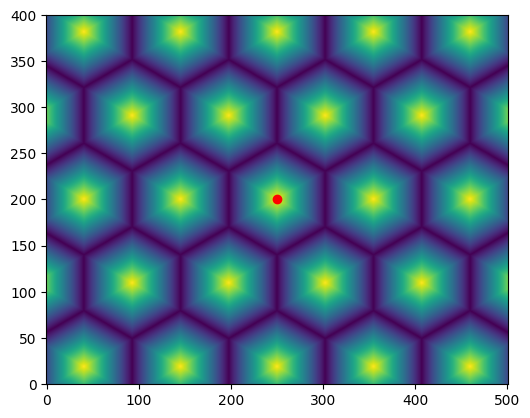

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure()
pln = HAC_holder[:,:,0]
plt.imshow(pln, origin='lower')
plt.plot(250,200,'ro')

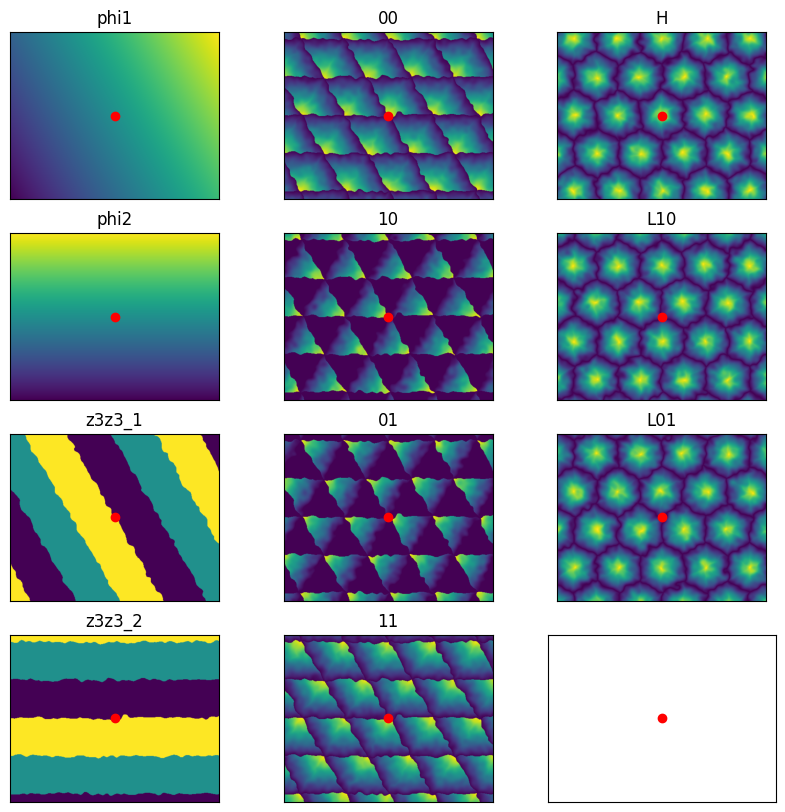

In [16]:
msb,nsb = 4,3

infoNow = Info_dirt
HHH_holder =infoNow[0]
HAC_holder=infoNow[1]
z3z3_holder=infoNow[2]

fig,axs = plt.subplots(msb,nsb,figsize=(10,10))
axs[0,1].imshow(HHH_holder[:,:,0], origin='lower')
axs[1,1].imshow(HHH_holder[:,:,1], origin='lower')
axs[2,1].imshow(HHH_holder[:,:,2], origin='lower')
axs[3,1].imshow(HHH_holder[:,:,3], origin='lower')

axs[0,2].imshow(HAC_holder[:,:,0], origin='lower')
axs[1,2].imshow(HAC_holder[:,:,1], origin='lower')
axs[2,2].imshow(HAC_holder[:,:,2], origin='lower')

axs[0,0].imshow(grid_B0, origin='lower')
axs[1,0].imshow(grid_B1, origin='lower')

axs[2,0].imshow(z3z3_holder[:,:,0], origin='lower')
axs[3,0].imshow(z3z3_holder[:,:,1], origin='lower')

tns = [['phi1','phi2','z3z3_1','z3z3_2'],['00','10','01','11'],['H','L10','L01']]

for isb in range(msb):
  for jsb in range(nsb):
    axs[isb,jsb].set_xticks([])
    axs[isb,jsb].set_yticks([])
    axs[isb,jsb].plot(250,200,'ro')
    try:
      tn = tns[jsb][isb]
      axs[isb,jsb].set_title(tn)
    except:
      a = 's'

# create hac segmentation

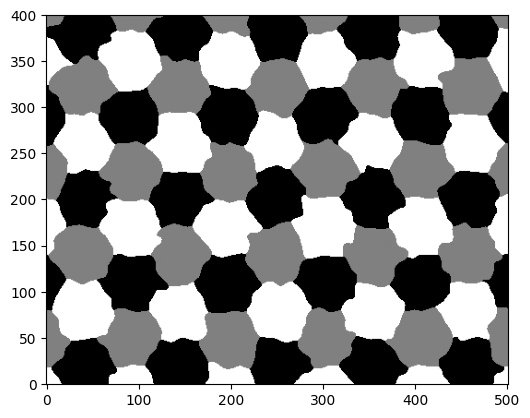

In [17]:
HAC_argmax = np.argmax(HAC_holder, axis=2)
plt.imshow(HAC_argmax, origin='lower',cmap='gray')

create hhh sgementation

Useful Examples

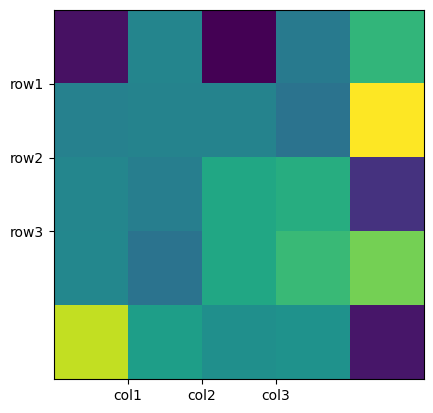

In [20]:
import numpy as np
import matplotlib.pyplot as plt

data = np.random.rand(5, 5)
plt.imshow(data, cmap='viridis')

# Change tick positions and labels
plt.xticks([0, 2, 4], ['A', 'B', 'C'])
plt.yticks([0, 2, 4], ['X', 'Y', 'Z'])

# Or directly use the Axes object
ax = plt.gca()
ax.set_xticks([0.5, 1.5, 2.5])
ax.set_xticklabels(['col1', 'col2', 'col3'])
ax.set_yticks([0.5, 1.5, 2.5])
ax.set_yticklabels(['row1', 'row2', 'row3'])

plt.show()


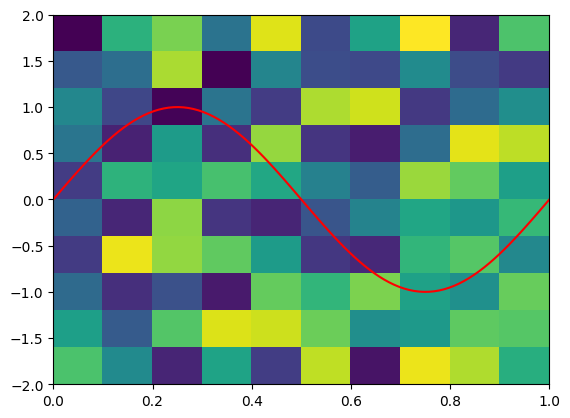

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터
img = np.random.rand(10, 10)

# x: 0~1, y: -2~2 범위로 표시
plt.imshow(img, extent=[0, 1, -2, 2], origin='lower', aspect='auto')

# 같은 축에 plot 사용
x = np.linspace(0, 1, 100)
y = np.sin(2 * np.pi * x)
plt.plot(x, y, color='red')

plt.show()
